# Text Classification - Vanilla Mixture of Experts (End to End, ahrd

*   List item
*   List item



----

## $\color{blue}{Sections:}$
* Preamble
* Admin - importing libraries
* Load - Loading our data from pandas
* Comparrison
* Dataset
* Model - Create PyTorch Vanilla Model
* Helper - Training helper functions
* Training - Training Loop


## $\color{blue}{Preamble:}$

This notebook recreates our text embeddings on the augmented dataset, then runs a comparisson between the original and the augmented embeddings. Then a classifier is trained on the augmented embeddings.


## $\color{blue}{Admin:}$

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/'


Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
%%capture
!pip install torch
!pip install dill

In [ ]:
import torch
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## $\color{blue}{Load:}$

In [ ]:
import pandas as pd
path = "class/datasets/"
#df_train = pd.read_pickle(path + "df_train")
df_train = pd.read_pickle(path + "df_train_augmentation.1")
df_dev = pd.read_pickle(path + "df_dev_augmentation.1")
df_test = pd.read_pickle(path + "df_test_augmentation.1")

In [ ]:
df_train.head()

,master,book_idx,chapter_idx,content,vanilla_embedding.1
0,Ulysses,0,0,"Halted, he peered down the dark winding stairs...","[-0.01852537, -0.021713095, 0.041504614, -0.00..."
1,Ulysses,0,0,"Then, catching sight of Stephen Dedalus, he be...","[-0.019168912, -0.0048065097, -0.012622914, -0..."
2,Ulysses,0,0,"Stephen Dedalus, displeased and sleepy, leaned...","[-0.025832051, -0.0060330997, -0.013755375, 0...."
3,Ulysses,0,0,he said sternly. He added in a preacher’s to...,"[-0.008437265, -0.011068143, 0.029162964, 0.00..."
4,Ulysses,0,0,He peered sideways up and gave a long slow whi...,"[-0.016204245, 0.015205742, 0.023865266, -0.01..."


In [ ]:
df_train_base = df_train.iloc[:11000] # get the subset of the non augmented datapoints
df_train_augmented = df_train.iloc[11000:]

## $\color{blue}{Comparison:}$

In [ ]:
# word count
# mean
# std
import numpy as np
def stats(series):
  word_count = []
  lstr = list(series)
  for sent in lstr:
    words = sent.strip().split()
    word_count.append(len(words))
  return np.mean(word_count), np.std(word_count)



In [ ]:
base_mean, base_std = stats(df_train_base['content'])
aug_mean, aug_std = stats(df_train_augmented['content'])
mean, std = stats(df_train['content'])

print(f'Original: mean = {round(base_mean,1)}, std = {round(base_std,1)}')
print(f'Augmented: mean = {round(aug_mean,1)}, std = {round(aug_std,1)}')
print(f'Overall: mean = {round(mean,1)}, std = {round(std,1)}')

Original: mean = 49.9, std = 16.4
Augmented: mean = 46.1, std = 12.6
Overall: mean = 48.2, std = 14.9


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def moving_average(data, window_size=5):
    """Calculate the moving average of the data with a specified window size."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def visualize(embedding1, embedding2, emb_1, emb_2, window_size=15):
    """
    Visualize two 300-dimensional embeddings using Seaborn to create a refined plot.
    Both embeddings are shown with positive values.

    Parameters:
    - embedding1: List or numpy array containing the first embedding.
    - embedding2: List or numpy array containing the second embedding.
    - window_size: Integer representing the smoothing window size.
    """

    # Ensure that both embeddings are numpy arrays
    embedding1 = np.array(embedding1)
    embedding2 = np.array(embedding2)

    # Smooth the embeddings using a moving average
    smooth_values1 = moving_average(embedding1, window_size)
    smooth_values2 = moving_average(embedding2, window_size)

    # Prepare data for plotting
    dimensions = np.arange(1, smooth_values1.size + 1)  # Adjust dimensions to match smoothed data size
    values1 = smooth_values1  # Positive values for embedding1
    values2 = smooth_values2  # Positive values for embedding2

    # Create a DataFrame for easier plotting with Seaborn
    data = pd.DataFrame({
        'Dimension': np.concatenate([dimensions, dimensions]),
        'Value': np.concatenate([values1, values2]),
        'Embedding': [emb_1] * smooth_values1.size + [emb_2] * smooth_values2.size
    })

    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 5))
    sns.set(style="whitegrid")

    # Create a line plot
    sns.lineplot(data=data, x='Dimension', y='Value', hue='Embedding', linewidth=1.5)

    # Enhance the aesthetics
    plt.xlabel('Dimension', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Embedding', fontsize=12, title_fontsize='13')
    plt.tight_layout()

    # Display the plot
    plt.show()

In [ ]:
embedding_base = df_train_base.iloc[1,4][:200]
embedding_augmented = df_train_augmented.iloc[1,4][:200]
embedding_comp = df_train.iloc[9568, 4][:200]

In [ ]:
def normalize(embedding):
    """
    Normalize an embedding to the range [0, 1] without using sklearn.

    Parameters:
    - embedding: List or numpy array containing the embedding.

    Returns:
    - Normalized embedding.
    """
    embedding = np.array(embedding)
    min_val = np.min(embedding)
    max_val = np.max(embedding)

    # Perform Min-Max normalization
    normalized = (embedding - min_val) / (max_val - min_val)
    return normalized
embedding_base = normalize(embedding_base)
embedding_augmented = normalize(embedding_augmented)
embedding_comp = normalize(embedding_comp)

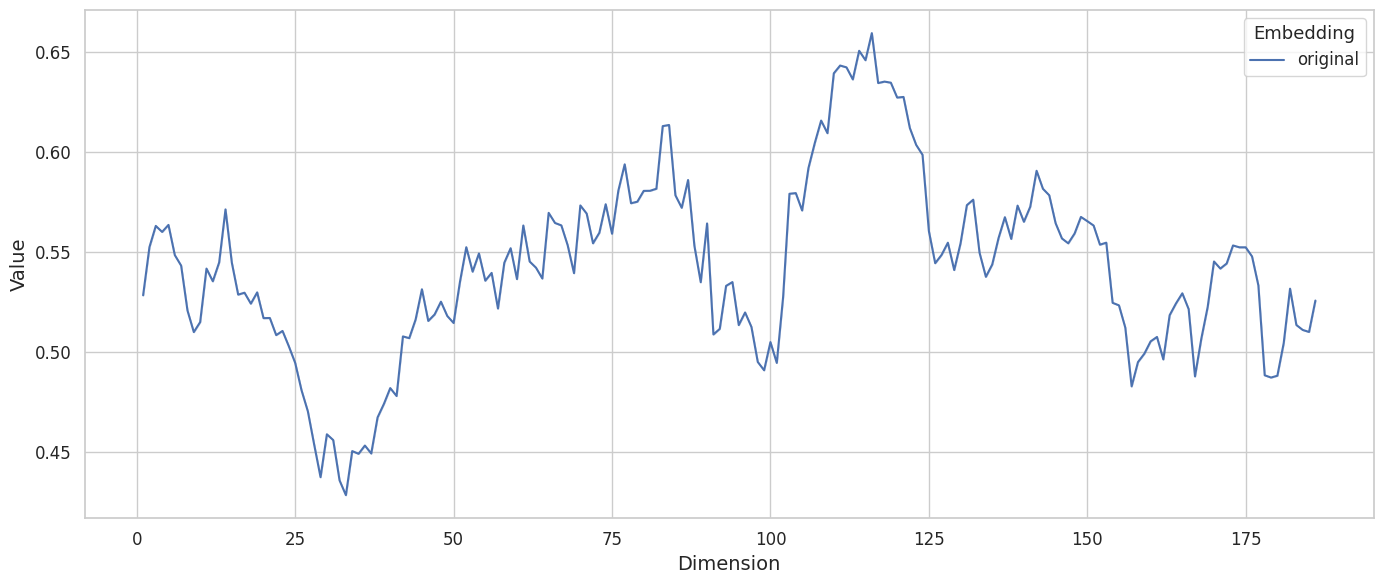

In [ ]:
visualize(embedding_base, embedding_base, 'original', 'original')

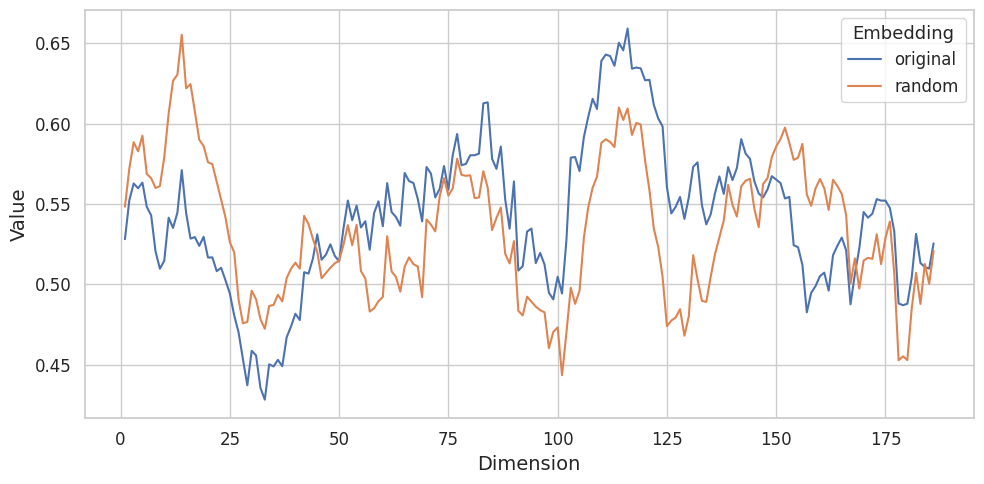

In [ ]:
visualize(embedding_base, embedding_comp, 'original', 'random')

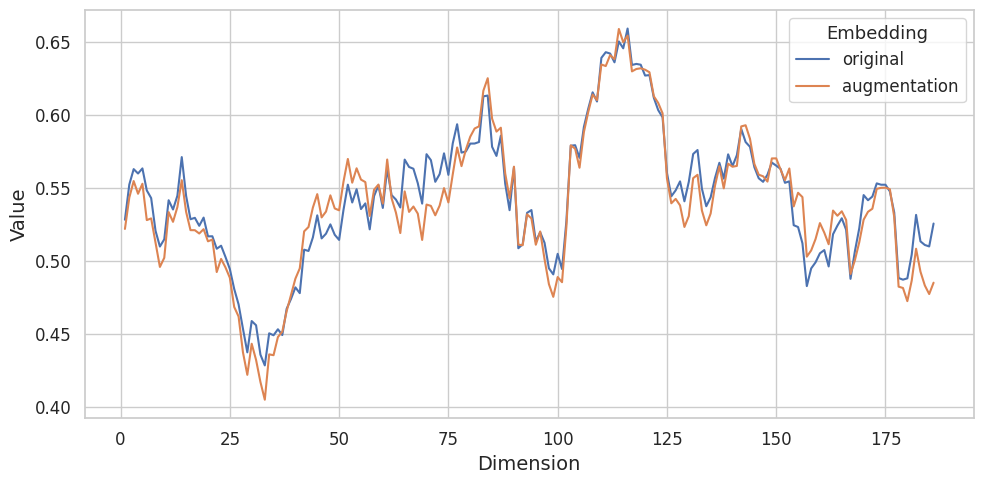

In [ ]:
visualize(embedding_base, embedding_augmented, 'original', 'augmentation')

## $\color{blue}{Dataset:}$

In [ ]:
df_train_base = df_train.iloc[:11000] # get the subset of the non augmented datapoints

In [ ]:
train_embeddings = [torch.tensor(array) for array in df_train_base['vanilla_embedding.1']]
# train_embeddings = [torch.tensor(array) for array in df_train['vanilla_embedding.1']]
train_x = torch.stack(train_embeddings).to(device)

dev_embeddings = [torch.tensor(array) for array in df_dev['vanilla_embedding.1']]
dev_x = torch.stack(dev_embeddings).to(device)

test_embeddings = [torch.tensor(array) for array in df_test['vanilla_embedding.1']]
test_x = torch.stack(test_embeddings).to(device)

In [ ]:
# train_y = torch.LongTensor(list(df_train['book_idx'])).to(device)
# dev_y = torch.LongTensor(list(df_dev['book_idx'])).to(device)
# test_y = torch.LongTensor(list(df_test['book_idx'])).to(device)

train_y = torch.LongTensor(list(df_train['chapter_idx'])).to(device)
dev_y = torch.LongTensor(list(df_dev['chapter_idx'])).to(device)
test_y = torch.LongTensor(list(df_test['chapter_idx'])).to(device)

In [ ]:
from torch.utils.data import Dataset, DataLoader
# assuming already tensors, allready on device
class VanillaDataset(Dataset):
  """Dataset maker"""

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __getitem__(self,index):
    x = self.x[index]
    y = self.y[index]

    return x, y

  def __len__(self):
    return len(self.y)


In [ ]:
train_dataset = VanillaDataset(train_x, train_y)
dev_dataset = VanillaDataset(dev_x, dev_y)
test_dataset = VanillaDataset(test_x, test_y)

In [ ]:
train_dataset[0][0].size()

torch.Size([768])

## $\color{blue}{Model:}$

In [ ]:
import torch.nn as nn

class DenseBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(DenseBlock, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.batch_norm = nn.BatchNorm1d(output_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.linear(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

class VanillaModel(nn.Module):
    def __init__(self, dropout_rate):
        super(VanillaModel, self).__init__()

        # Define the dense blocks
        self.block1 = DenseBlock(768, 400, dropout_rate)
        self.block2 = DenseBlock(400, 200, dropout_rate)
        self.final_layer = nn.Linear(200, 70)

        self.initialize_weights()

    def forward(self, x):
        x = self.block1(x)  # Bx768 -> Bx400
        x = self.block2(x)  # Bx400 -> Bx200
        x = self.final_layer(x)  # Bx200 -> Bx70

        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


## $\color{blue}{Helper:}$

In [ ]:
def accuracy(outputs, labels):
    # argmax to get predicted classes
    _, predicted = torch.max(outputs, 1)

    # count correct
    correct = (predicted == labels).sum().item()

    # get average
    acc = correct / labels.size(0)  # Total number of samples
    return acc

In [ ]:
import numpy as np

def train(model, train_loader, criterion, optimizer):
    model.train()
    epoch_train_losses = []
    epoch_train_accuracy = []

    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(x)
        train_loss = criterion(out, y)
        train_accuracy = accuracy(out, y)

        epoch_train_losses.append(train_loss.item())
        epoch_train_accuracy.append(train_accuracy)

        # Backpropagation and optimization
        train_loss.backward()
        optimizer.step()

    return np.mean(epoch_train_losses), np.mean(epoch_train_accuracy)

In [ ]:
def validate(model, dev_loader, criterion):
    model.eval()
    epoch_dev_losses = []
    epoch_dev_accuracy = []

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(dev_loader):
            out = model(x)

            dev_loss = criterion(out, y)
            dev_accuracy = accuracy(out, y)

            epoch_dev_losses.append(dev_loss.item())
            epoch_dev_accuracy.append(dev_accuracy)

    return np.mean(epoch_dev_losses), np.mean(epoch_dev_accuracy)

In [ ]:
from collections import namedtuple
Stats = namedtuple('Stats', [
    'train_loss',
    'train_accuracy',
    'dev_loss',
    'dev_accuracy',
    'epoch',
    'bs',
    'lr',
    'alpha',
    'max_accuracy'
])

In [ ]:
def gen_config(lr_low, lr_high, alpha_low, alpha_high, b_size, b_step):
  bs_list = [b_size - b_step, b_size, b_size + b_step]
  bs = int(2**np.random.choice(bs_list))
  lr = round(10**float(np.random.uniform(lr_low,lr_high)),6)
  alpha = round(10**float(np.random.uniform(alpha_low,alpha_high)),6)
  return lr, alpha, bs

In [ ]:
def gen_ranges( lr, lr_range, alpha, alpha_range, b_size, iteration):

  lr_center = lr
  lr_low = lr_center - lr_range/2
  lr_high = lr_center + lr_range/2
  lr_diff = lr_high - lr_low

  alpha_center = alpha
  alpha_low = alpha_center - alpha_range/2
  alpha_high = alpha_center + alpha_range/2
  alpha_diff = alpha_high - alpha_low

  b_step = 2 - iteration

  return (lr_low, lr_high, alpha_low, alpha_high, b_size, b_step)

In [ ]:
def search_stats(results):
  best_stats = None
  max_dev_accuracy = 0
  for i in range(len(results)):
    acc = results[i].dev_accuracy
    if acc > max_dev_accuracy:
      best_stats = results[i]
      max_dev_accuracy = acc
  return best_stats

## $\color{blue}{Training:}$

In [ ]:
def tv_run(epochs, model, bs, lr, alpha, max_accuracy, path, verbose = 0):
  """
  Runs a training setup
  verbose == 1 - print model results
  verbose == 2 -> print epoch and model results
  """
  if bs < 32:
    bs = 32
  # Set up new model
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=alpha)

  # Prepare data loaders
  train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
  dev_loader = DataLoader(dev_dataset, batch_size=bs)

  # Hold epoch stats
  train_losses = []
  train_accuracy = []
  dev_losses = []
  dev_accuracy = []
  epoch_holder = []

  # Break if no improvement
  current_best = 0
  no_improvement = 0

  # Run epochs
  for epoch in range(epochs):

    # break out of epochs
    if no_improvement >= 6:
      break

    # call training and validation functions
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    dev_loss, dev_acc = validate(model, dev_loader, criterion)

    # Store epoch stats
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    dev_losses.append(dev_loss)
    dev_accuracy.append(dev_acc)
    epoch_holder.append(epoch + 1)

    # check for improvement
    if dev_acc > current_best:
      current_best = dev_acc
      no_improvement = 0
    else:
      no_improvement += 1

    # save best model
    if dev_acc > max_accuracy:
      torch.save(model.state_dict(), path)
      max_accuracy = dev_acc

    # optionally print epoch results
    if verbose == 2:
      print(f'\n --------- \nEpoch: {epoch + 1}\n')
      print(f'Epoch {epoch + 1} train loss: {train_loss:.4f}')
      print(f'Epoch {epoch + 1} train accuracy: {train_acc:.4f}')
      print(f'Epoch {epoch + 1} dev loss: {dev_loss:.4f}')
      print(f'Epoch {epoch + 1} dev accuracy: {dev_acc:.4f}')

  # save best results
  max_ind = np.argmax(dev_accuracy)

  stats = Stats(
      train_losses[max_ind],
      train_accuracy[max_ind],
      dev_losses[max_ind],
      dev_accuracy[max_ind],
      epoch_holder[max_ind],
      bs, lr, alpha,
      max_accuracy
  )

  # optionally print model results
  if verbose in [1,2]:
    print('\n ######## \n')
    print(f'bs:{stats.bs}, lr:{stats.lr}, alpha:{stats.alpha} @ epoch {stats.epoch}.')
    print(f'TL:{stats.train_loss}, TA:{stats.train_accuracy}.')
    print(f'DL:{stats.dev_loss}, DA:{stats.dev_accuracy}')

  return stats

In [ ]:
"""
Main Admin
"""
epochs = 50
max_accuracy = 0
path = "class/models/augmented_vanilla.1base.pt"
results = []

"""
init random search
lr [10^-5 - 10^-1]
alpha [10^-5 - 10^-1]
bs [8, 32, 128]
"""
lr_low = -5
lr_high = -1
lr_range = lr_high - lr_low

alpha_low = -5
alpha_high = -1
alpha_range = alpha_high - alpha_low

b_size = 5
b_step = 2

count = 0

"""
Hyperparameter Search
"""

for i in range(3):
  # debug
  print(f'round: {i}')
  print(f'lr_low{lr_low}, lr_high{lr_high}, lr_range{lr_range}')
  print(f'alpha_low{alpha_low}, lr_high{alpha_high}, lr_range{alpha_range}')
  print(f'b_size{b_size}')
  print(f'b_step{b_step}')
  print('max', max_accuracy)

  for j in range(9):
    count += 1
    print(count)

    # get config
    lr, alpha, bs = gen_config(lr_low, lr_high, alpha_low, alpha_high, b_size, b_step)

    # define model
    model = VanillaModel(.1) # model with dropout
    model = model.to(device)

    # run training
    res = tv_run(epochs, model, bs, lr, alpha, max_accuracy, path, verbose = 2)
    max_accuracy = res.max_accuracy
    results.append(res)

  # get best result of the round or even so far
  stats = search_stats(results)


  print(stats) # debug

  # reconfigure the new hypers
  lr = np.log10(stats.lr)
  lr_range = lr_range / 3

  alpha = np.log10(stats.alpha)
  alpha_range = alpha_range / 3

  bs = np.log2(stats.bs)

  config = gen_ranges(lr, lr_range, alpha, alpha_range, bs, i + 1)
  lr_low, lr_high, alpha_low, alpha_high, b_size, b_step = config
  lr_range = lr_high - lr_low
  alpha_range = alpha_high - alpha_low


Streaming output truncated to the last 5000 lines.
Epoch 13 train loss: 0.5593
Epoch 13 train accuracy: 0.8933
Epoch 13 dev loss: 1.4462
Epoch 13 dev accuracy: 0.5898

 --------- 
Epoch: 14

Epoch 14 train loss: 0.4866
Epoch 14 train accuracy: 0.9130
Epoch 14 dev loss: 1.4338
Epoch 14 dev accuracy: 0.5969

 --------- 
Epoch: 15

Epoch 15 train loss: 0.4294
Epoch 15 train accuracy: 0.9276
Epoch 15 dev loss: 1.4402
Epoch 15 dev accuracy: 0.5982

 ######## 

bs:128, lr:0.000148, alpha:0.002652 @ epoch 9.
TL:0.9409740287810564, TA:0.7887927446209015.
DL:1.5031265914440155, DA:0.5987372248427673
3

 --------- 
Epoch: 1

Epoch 1 train loss: 2.3441
Epoch 1 train accuracy: 0.3720
Epoch 1 dev loss: 1.7822
Epoch 1 dev accuracy: 0.4721

 --------- 
Epoch: 2

Epoch 2 train loss: 1.6852
Epoch 2 train accuracy: 0.5194
Epoch 2 dev loss: 1.6857
Epoch 2 dev accuracy: 0.5250

 --------- 
Epoch: 3

Epoch 3 train loss: 1.4076
Epoch 3 train accuracy: 0.5866
Epoch 3 dev loss: 1.7860
Epoch 3 dev accuracy: 0.

bs:32, lr:0.000279, alpha:0.003047 @ epoch 18.

In [ ]:
import dill
def save_results_to_file(namedtuples, filename):
    """Saves a list of namedtuples to a specified file using dill."""
    with open(filename, 'wb') as f:
        dill.dump(namedtuples, f)

def load_results_from_file(filename):
    """Loads a list of namedtuples from a specified file using dill."""
    with open(filename, 'rb') as f:
        return dill.load(f)

In [ ]:
path = 'class/results/'
save_results_to_file(results, path + 'vanilla.1.pk')